In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from scipy.special import erfc
import time
import copy
import random
import typing

In [2]:
def analytical_solution(x, t, D, max_range=10):
    """
    Calculate the analytical diffusion solution using the complementary error function.

    Parameters:
    -----------
    x : array_like
        Spatial coordinates for evaluation (1D array).
    t : float
        Time at which to evaluate the solution (must be > 0).
    D : float
        Diffusion coefficient (positive value).
    max_range : int, optional
        Number of terms in the summation (default is 10).

    Returns:
    --------
    ndarray
        Analytical solution at the specified spatial points and time.
    """
    
    sum_analytical = np.zeros_like(x)
    for i in range(max_range):
        sum_analytical += (erfc((1 - x + 2 * i) / (2 * np.sqrt(D * t))) - 
                           erfc((1 + x + 2 * i) / (2 * np.sqrt(D * t))))

    return sum_analytical


In [3]:
def initialize_grid(N: int):
    """
    Initialize a 2D grid of size N x N with the bottom row set to 1.0.

    Parameters:
    -----------
    N : int
        Size of the grid (number of rows and columns).

    Returns:
    --------
    ndarray
        A 2D array representing the grid.
    """
    grid = np.zeros((N, N))
    grid[-1, :] = 1.0
    
    return grid


In [4]:
def get_next_grid(grid, N, dt, D, dx, method, omega):
    """
    Compute the next iteration of the 2D grid based on the specified method.

    Parameters:
    -----------
    grid : ndarray
        The current state of the grid.
    N : int
        Size of the grid (number of rows and columns).
    dt : float
        Time step for the simulation.
    D : float
        Diffusion coefficient.
    dx : float
        Spatial step size.
    method : str
        The numerical method to use ('Explicit', 'Jacobi', 'Gauss-Seidel', or 'SOR').
    omega : float
        Relaxation factor for the SOR method.

    Returns:
    --------
    tuple
        - new_grid : ndarray
          The updated grid after applying the numerical method.
        - maximum_difference : float, optional
          The maximum difference between the old and new grid values (only for Jacobi, Gauss-Seidel, and SOR methods).
    """
    new_grid = np.copy(grid)

    if method == 'Explicit':
        for i in range(1, N - 1):
            for j in range(N):
                new_grid[i, j] = grid[i, j] + (dt * D / dx**2) * (
                    grid[i - 1, j] + grid[i + 1, j] + grid[i, (j - 1) % N] + grid[i, (j + 1) % N] - 4 * grid[i, j]
                )
        return new_grid, None

    elif method == 'Jacobi':
        maximum_difference = 0
        for i in range(1, N - 1):
            for j in range(N):
                new_grid[i, j] = 0.25 * (
                    grid[i - 1, j] + grid[i + 1, j] + grid[i, (j - 1) % N] + grid[i, (j + 1) % N]
                )
                maximum_difference = max(maximum_difference, abs(new_grid[i, j] - grid[i, j]))
        return new_grid, maximum_difference  

    elif method == 'Gauss-Seidel':
        maximum_difference = 0
        for i in range(1, N - 1):
            for j in range(N):
                old_value = new_grid[i, j]
                new_grid[i, j] = 0.25 * (
                    new_grid[i - 1, j] + grid[i + 1, j] + new_grid[i, (j - 1) % N] + grid[i, (j + 1) % N]
                )
                maximum_difference = max(maximum_difference, abs(new_grid[i, j] - old_value))
        return new_grid, maximum_difference  

    elif method == 'SOR':
        maximum_difference = 0
        for i in range(1, N - 1):
            for j in range(N):
                old_value = grid[i, j]
                gauss_seidel_value = 0.25 * (
                    new_grid[i - 1, j] + grid[i + 1, j] + new_grid[i, (j - 1) % N] + grid[i, (j + 1) % N]
                )
                new_grid[i, j] = (1 - omega) * old_value + omega * gauss_seidel_value
                maximum_difference = max(maximum_difference, abs(new_grid[i, j] - old_value))
        return new_grid, maximum_difference


In [5]:
def simulate_diffusion_2d(N, D, dx, dt, T, method="Explicit", omega=1.85, tol= 1e-5, save_interval=100):
    """Simulates the process of diffusion through the entire grid 
    omega: relaxation parameter
    save_interval; interval at which the grid is saved"""

    c = initialize_grid(N)
    c_history = [c.copy()]

    n_steps = int(T / dt)
    time_points = [0.0]
    special_times = [0.001, 0.01, 0.1, 1.0]

 
    if method == 'Explicit':
      for step in range(1, n_steps + 1):
          c = get_next_grid(c, N, dt, D, dx, method=method, omega=omega)
          current_time = step * dt

          if (step % save_interval == 0) or any(abs(current_time - t) < dt for t in special_times):
              time_points.append(current_time)
              c_history.append(c.copy())
      
      return time_points, c_history
    
    elif method in ['Jacobi', 'Gauss-Seidel', 'SOR']:
      iters = 0
      max_difference= []
      while True:  
          c, max_diff = get_next_grid(c, N, dt, D, dx, method=method, omega=omega)
          
          if iters % save_interval == 0:
              c_history.append(c.copy())
              
          if max_diff < tol:
              print(f"Converged after {iters} iterations")
              break

          max_difference.append(max_diff)
          iters += 1
          
      return iters, c_history, max_difference

   

In [6]:
def validate_against_analytical(x_points, times, D, c_history, N):
    """
    Validate the numerical solution against the analytical solution.

    Parameters:
    -----------
    x_points : array-like
        Spatial points where the concentration is evaluated.
    times : array-like
        Time instances at which the numerical solutions are available.
    D : float
        Diffusion coefficient.
    c_history : list of ndarray
        List containing the concentration fields at each time step.
    N : int
        Size of the grid (number of rows and columns).
    """
    
    plt.figure(figsize=(12, 8))
    mid_x = N // 2
    
    for i, t in enumerate(times):
        if t > 0:  
            numerical = c_history[i][:, mid_x]
            analytical = np.array([analytical_solution(x, t, D) for x in x_points])
            
            # Plot both solutions
            plt.plot(x_points, numerical, 'o-', label=f'Numerical, t={t:.3f}')
            plt.plot(x_points, analytical, '--', label=f'Analytical, t={t:.3f}')
    
    plt.xlabel('y position')
    plt.ylabel('Concentration c(y)')
    plt.title('Comparison between numerical and analytical solutions')
    plt.legend()
    plt.grid(True)
    plt.savefig('validation_plot.png', dpi=300)
    plt.show()


In [7]:
def plot_2d_concentration(times, c_history, N, dx):
    """
    Plot 2D concentration fields for given time steps.

    Parameters:
    -----------
    times : array-like
        List of time steps at which the concentration fields are evaluated.
    c_history : list of ndarray
        List containing the concentration fields at each time step.
    N : int
        Size of the grid (number of rows and columns).
    dx : float
        Spatial resolution of the grid.
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    x = np.linspace(0, (N-1) * dx, N)
    y = np.linspace(0, (N-1) * dx, N)
    X, Y = np.meshgrid(x, y)
    
    for i, (t, c) in enumerate(zip(times, c_history)):
        if i < len(axes):
            ax = axes[i]
            im = ax.pcolormesh(X, Y, c, cmap='viridis', shading='auto')
            ax.set_title(f't = {t:.3f}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            fig.colorbar(im, ax=ax, label='Concentration')
    
    plt.tight_layout()
    plt.savefig('concentration_plots.png', dpi=300)
    plt.show()


In [9]:
def create_animation(times, c_history, N, dx):
    """
    Create an animation of the concentration field over time.

    Parameters:
    -----------
    times : array-like
        List of time steps for the animation.
    c_history : list of ndarray
        List containing the concentration fields at each time step.
    N : int
        Size of the grid (number of rows and columns).
    dx : float
        Spatial resolution of the grid.

    Returns:
    --------
    ani : FuncAnimation
        The created animation object.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x = np.linspace(0, (N-1) * dx, N)
    y = np.linspace(0, (N-1) * dx, N)
    X, Y = np.meshgrid(x, y)
    
    # Initial plot
    im = ax.pcolormesh(X, Y, c_history[0], cmap='viridis', shading='auto', vmin=0, vmax=1)
    title = ax.set_title(f't = {times[0]:.5f}')
    fig.colorbar(im, ax=ax, label='Concentration')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    def update(frame):
        im.set_array(c_history[frame].ravel())
        title.set_text(f't = {times[frame]:.5f}')
        return [im, title]
    
    ani = FuncAnimation(fig, update, frames=range(len(times)), blit=True)
    ani.save('diffusion_animation.gif', writer='pillow', fps=15)
    plt.show()
    
    return ani


In [10]:
def compare_analytic_solutions(N, L, D, dx, dt, T, method='Explicit'):
    """
    Compare the analytical solution with a numerical method to check simulation accuracy.

    Parameters:
    -----------
    N : int
        Number of grid points in one dimension.
    L : float
        Length of the domain.
    D : float
        Diffusion coefficient.
    dx : float
        Spatial resolution of the grid.
    dt : float
        Time step for the simulation.
    T : float
        Total simulation time.
    method : str
        Numerical method to use ('Explicit' is default).

    Returns:
    --------
    ani : FuncAnimation
        The created animation object of the concentration field over time.
    """
    time_points, c_history, _ = simulate_diffusion_2d(N, D, dx, dt, T, method, save_interval=100)
    x_points = np.linspace(0, L, N)
    target_times = [0, 0.001, 0.01, 0.1, 1.0]
    selected_indices = []
    selected_times = []

    for target in target_times:
        idx = np.argmin(np.abs(np.array(time_points) - target))  # Finding indices closest to the target timesteps
        selected_indices.append(idx)
        selected_times.append(time_points[idx])

    validate_against_analytical(x_points, [time_points[i] for i in selected_indices], D, [c_history[i] for i in selected_indices], N)
    plot_2d_concentration([time_points[i] for i in selected_indices], [c_history[i] for i in selected_indices], N, dx)
    ani = create_animation(time_points, c_history, N, dx)
    
    return ani


#### Initial Conditions for the Simulation to be used all throughout the code

In [14]:
N = 50      
L = 1.0   
dx= L/(N)  
D = 1.0              # Diffusion coefficient
dt = 0.25 * dx**2 / D  
T = 1.0   


In [19]:
def compare_numerical_methods(N, D, dx, dt, T, L, methods=['Jacobi', 'Gauss-Seidel', 'SOR'], tol= 1e-5, omega=1.8):
    """
    Compares numerical methods for solving the diffusion equation.
    Plots the concentration profiles for each method against the analytical solution.
    
    Parameters:
    - N: Number of grid points
    - D: Diffusion coefficient
    - dx: Spatial step size
    - dt: Time step size
    - T: Final simulation time
    - L: Length of the domain
    - methods: List of numerical methods to compare
    - omega: Relaxation parameter for SOR
    """
    y_values = np.linspace(0, L, N)
    analytic_vals = [float(analytical_solution(y, T, D)) for y in y_values]
    
    plt.figure(figsize=(10, 6))
    
    for method in methods:
        iters, c_history, _ = simulate_diffusion_2d(N, D, dx, dt, T, method=method, tol= tol, omega=omega)
        c_history = np.array(c_history)
        mid_x = len(c_history[-1]) // 2  # Midpoint in x-direction
        c_values = [row[mid_x] for row in c_history[-1]]
        
        plt.plot(y_values, c_values, label=f'{method} Method', marker='o')
    
    plt.plot(y_values, analytic_vals, label='Analytical Solution', linestyle='--', color='black')

    plt.xlabel('Y Values')
    plt.ylabel('Concentration')
    plt.title(f'Comparison of {method} Method with Analytical Solution after {iters} iterations')
    plt.legend()
    plt.grid()
    plt.show()

Converged after 4067 iterations


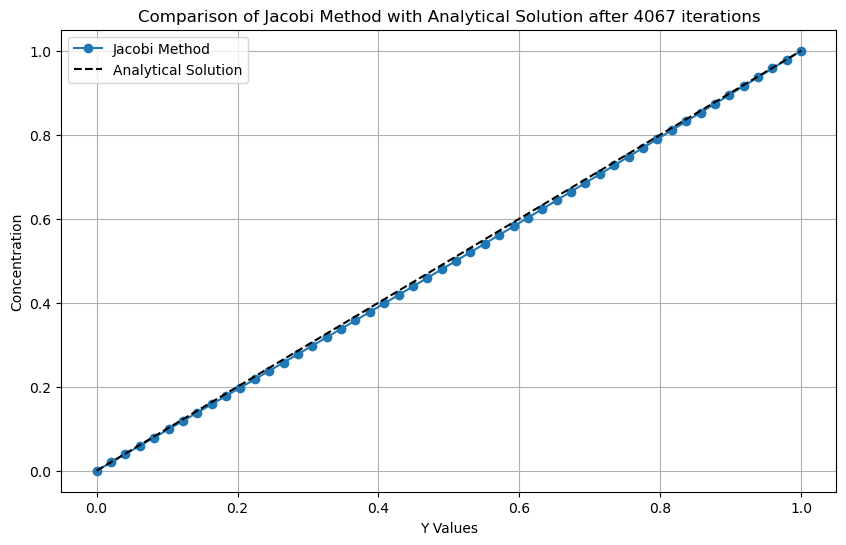

In [20]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['Jacobi'])

Converged after 2406 iterations


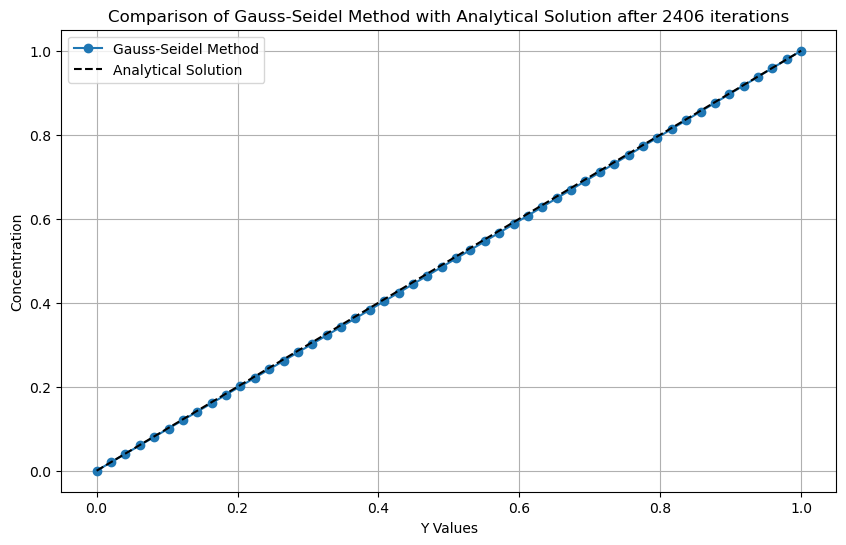

In [21]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['Gauss-Seidel'])

Converged after 424 iterations


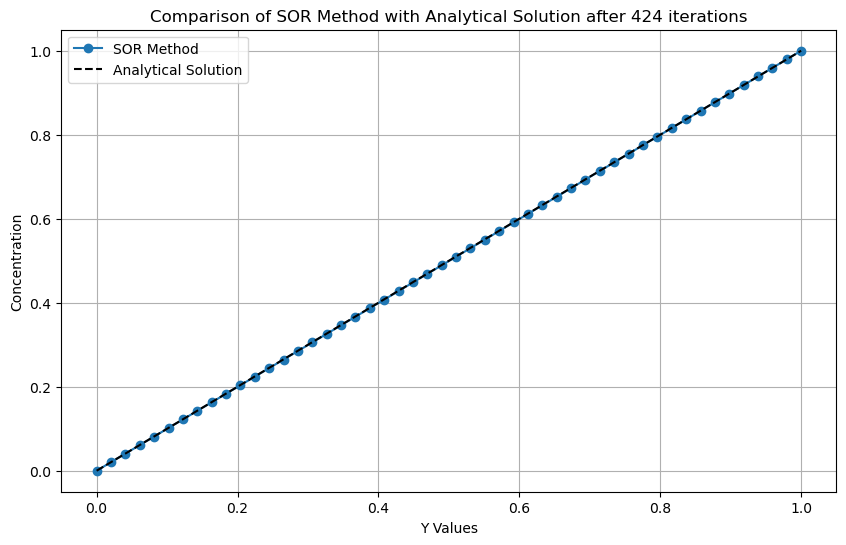

In [22]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['SOR'], omega=1.8)

In [263]:
# def tolerances_comparison(N, D, dx, dt, T, tol_values=None, omega=1.7):
#     if tol_values is None:
#         tol_values = np.logspace(-5, -14, 6)  # Logarithmically spaced tolerance values

#     methods = ['Jacobi', 'Gauss-Seidel', 'SOR']
#     iter_counts = {method: [] for method in methods}

#     for method in methods:
#         for tol in tol_values:
#             iters, _ ,_= simulate_diffusion_2d(N, D, dx, dt, T, method=method, tol=tol, omega=omega)
#             iter_counts[method].append(iters)

 
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

#     for i, method in enumerate(methods):
#         axes[i].plot(tol_values, iter_counts[method], marker='o', linestyle='-')
#         axes[i].set_xscale('log')  
#         axes[i].set_xlabel('Tolerance')
#         axes[i].set_title(f'{method} Method')
#         axes[i].grid(True)

#     axes[0].set_ylabel('Iterations')
#     plt.suptitle('Iterations vs. Tolerance for Different Methods')
#     plt.tight_layout()
#     plt.show()


Converged after 424 iterations
424


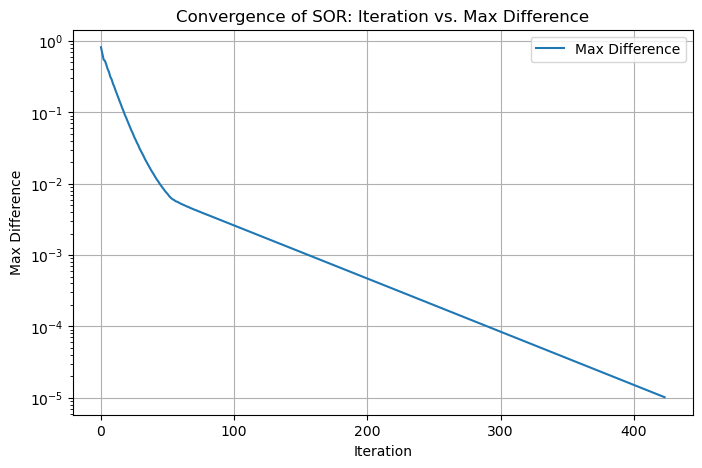

In [288]:
# iters, _ ,max_difference = simulate_diffusion_2d(N, D, dx, dt, T, method='SOR', tol=1e-5, omega=1.8)
# # iteration = np.arange(iters+1)
# iteration = np.arange(iters)

# # Plot
# print(len(max_difference))
# plt.figure(figsize=(8, 5))
# plt.plot(iteration, max_difference, linestyle='-', label="Max Difference")

# # Labels and title
# plt.xlabel("Iteration")
# plt.ylabel("Max Difference")
# plt.title("Convergence of SOR: Iteration vs. Max Difference")
# plt.yscale("log")  # Use log scale if the error decreases exponentially
# plt.grid(True)
# plt.legend()
# plt.show()



In [23]:
def compare_iterative_methods(N, D, dx, dt, T, tol=1e-5, save_interval=1):
    """
    Compare convergence of Jacobi, Gauss-Seidel, and SOR methods
    
    Parameters:
    -----------
    N : int
        Grid size
    D : float
        Diffusion coefficient
    dx : float
        Grid spacing
    dt : float
        Time step
    T : float
        Total simulation time
    tol : float
        Convergence tolerance
    save_interval : int
        Interval for saving convergence data
        
    Returns:
    --------
    figure : matplotlib figure
        Plot comparing convergence of different methods
    """
    
    results = {}
    

    iters, _, max_diff = simulate_diffusion_2d(N, D, dx, dt, T, method='Jacobi', tol=tol)
    results['Jacobi'] = max_diff

    iters, _, max_diff = simulate_diffusion_2d(N, D, dx, dt, T, method='Gauss-Seidel', tol=tol)
    results['Gauss-Seidel'] = max_diff
    
    omega_values = [1.5, 1.65, 1.8]
    for omega in omega_values:
        iters, _, max_diff = simulate_diffusion_2d(N, D, dx, dt, T, method='SOR', omega=omega, tol=tol)
        results[f'SOR (ω={omega})'] = max_diff
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Plot each method
    for method, max_diff in results.items():
        iterations = np.arange(len(max_diff))
        plt.plot(iterations, max_diff, label=method)
    
    plt.xlabel('Iteration')
    plt.ylabel('Maximum Difference')
    plt.title('Convergence Comparison of Iterative Methods')
    plt.yscale('log')  
    plt.grid(True)
    plt.legend()
    
   
    plt.savefig('convergence_comparison.png', dpi=300)
    plt.show()  
    
    return plt.gcf()  


Converged after 4067 iterations
Converged after 2406 iterations
Converged after 1008 iterations
Converged after 704 iterations
Converged after 424 iterations


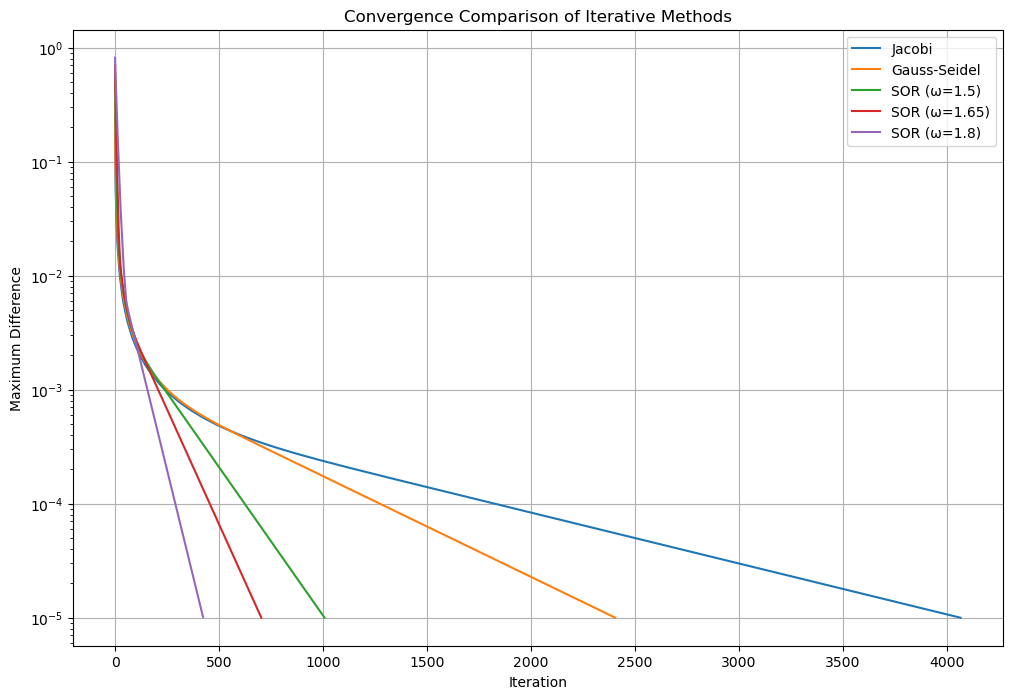

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
compare_iterative_methods(N, D, dx, dt, T, tol=1e-5)

Converged after 4067 iterations
Converged after 7987 iterations
Converged after 11908 iterations
Converged after 15828 iterations
Converged after 19749 iterations
Converged after 2406 iterations
Converged after 4387 iterations
Converged after 6367 iterations
Converged after 8348 iterations
Converged after 10328 iterations
Converged after 609 iterations
Converged after 973 iterations
Converged after 1336 iterations
Converged after 1700 iterations
Converged after 2064 iterations


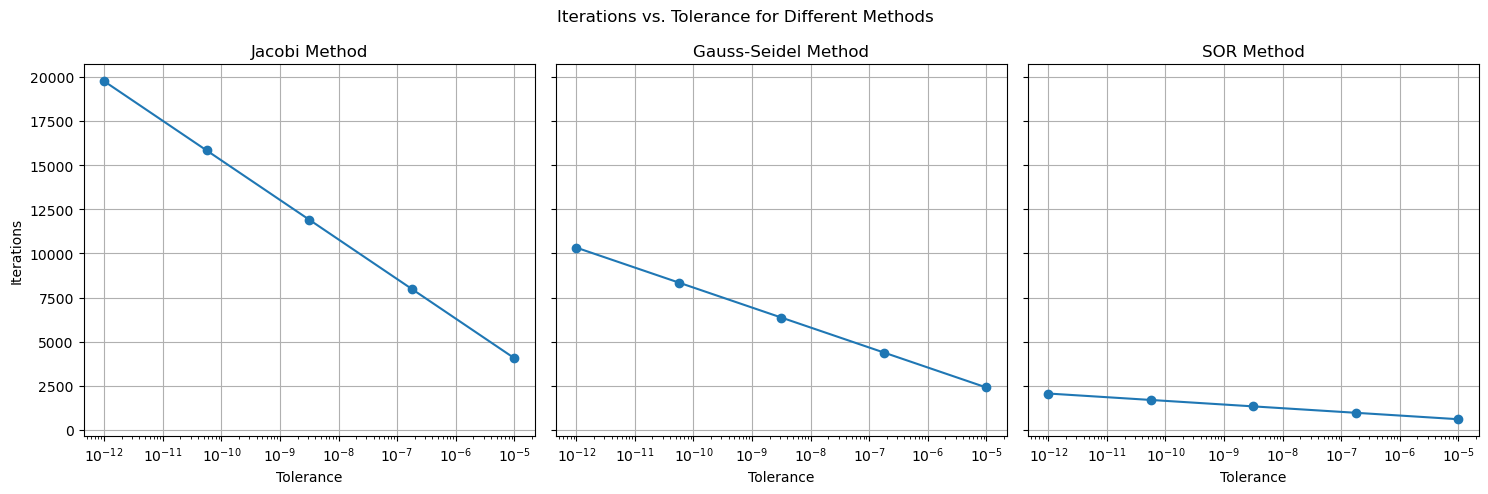

In [264]:
tol_values = np.logspace(-5, -12, 5)
tolerances_comparison(N, D, dx, dt, T, tol_values)

In [271]:
import numpy as np
import matplotlib.pyplot as plt

def optimal_omega(N, D, dx, dt, T, tol=1e-5, omega_list=None):
    # Use a default range of omega values if none is provided
    if omega_list is None:
        omega_list = np.linspace(1.1, 1.9, 20)
    
    iterations = []
    

    for omega in omega_list:
        iters, _ ,_= simulate_diffusion_2d(N, D, dx, dt, T, method='SOR', tol=tol, omega=omega)
        iterations.append(iters)
    
    plt.figure(figsize=(8, 5))
    plt.plot(omega_list, iterations, marker='o', linestyle='-')
    plt.xlabel('ω (Relaxation Parameter)')
    plt.ylabel('Number of Iterations')
    plt.title('Convergence Iterations vs. ω')
    plt.grid(True)
    plt.show()
    
    optimal_idx = np.argmin(iterations)
    optimal_value = omega_list[optimal_idx]
    print(f"Optimal ω: {optimal_value} with {iterations[optimal_idx]} iterations")
    
    return optimal_value


Converged after 424 iterations
Converged after 415 iterations
Converged after 405 iterations
Converged after 396 iterations
Converged after 386 iterations
Converged after 377 iterations
Converged after 367 iterations
Converged after 358 iterations
Converged after 348 iterations
Converged after 338 iterations
Converged after 329 iterations
Converged after 319 iterations
Converged after 310 iterations
Converged after 300 iterations
Converged after 290 iterations
Converged after 281 iterations
Converged after 274 iterations
Converged after 274 iterations
Converged after 281 iterations
Converged after 312 iterations


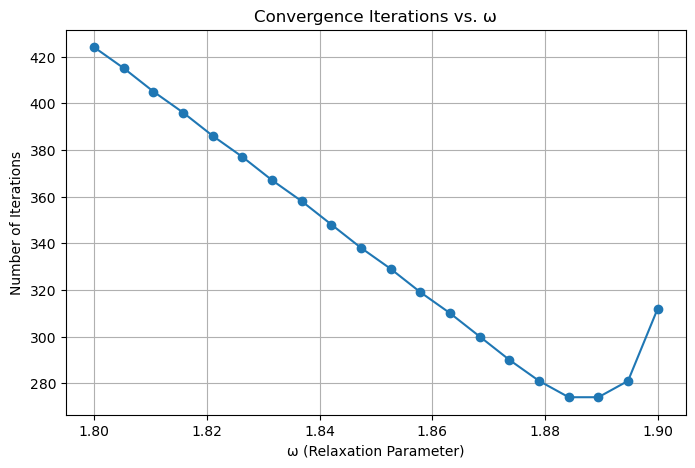

Optimal ω: 1.8842105263157893 with 274 iterations


1.8842105263157893

In [277]:
omega_list = np.linspace(1.8, 1.90, 20)
optimal_omega(N, D, dx, dt, T, tol=1e-5, omega_list= omega_list)

Converged after 59 iterations
Converged after 52 iterations
Converged after 50 iterations
Converged after 67 iterations
Converged after 113 iterations
Converged after 392 iterations


/var/folders/_1/0wm31tv93_g2x0n62x6b_ht80000gn/T/ipykernel_87358/2210900836.py:70: RuntimeWarning: overflow encountered in scalar subtract
  maximum_difference = max(maximum_difference, abs(new_grid[i, j] - old_value))
/var/folders/_1/0wm31tv93_g2x0n62x6b_ht80000gn/T/ipykernel_87358/2210900836.py:67: RuntimeWarning: overflow encountered in scalar add
  new_grid[i - 1, j] + grid[i + 1, j] + new_grid[i, (j - 1) % N] + grid[i, (j + 1) % N]
/var/folders/_1/0wm31tv93_g2x0n62x6b_ht80000gn/T/ipykernel_87358/2210900836.py:69: RuntimeWarning: invalid value encountered in scalar add
  new_grid[i, j] = (1 - omega) * old_value + omega * gauss_seidel_value
/var/folders/_1/0wm31tv93_g2x0n62x6b_ht80000gn/T/ipykernel_87358/2210900836.py:67: RuntimeWarning: invalid value encountered in scalar add
  new_grid[i - 1, j] + grid[i + 1, j] + new_grid[i, (j - 1) % N] + grid[i, (j + 1) % N]
/var/folders/_1/0wm31tv93_g2x0n62x6b_ht80000gn/T/ipykernel_87358/2210900836.py:69: RuntimeWarning: overflow encountered i

Converged after 20302 iterations
broken
For N=10, Optimal ω: 1.6111111111111112 with 50 iterations
Converged after 424 iterations
Converged after 375 iterations
Converged after 328 iterations
Converged after 283 iterations
Converged after 239 iterations
Converged after 196 iterations
Converged after 163 iterations
Converged after 616 iterations
Converged after 16772 iterations
broken
For N=30, Optimal ω: 1.8333333333333333 with 163 iterations
Converged after 1008 iterations
Converged after 892 iterations
Converged after 780 iterations
Converged after 672 iterations
Converged after 567 iterations
Converged after 465 iterations
Converged after 364 iterations
Converged after 274 iterations
Converged after 71549 iterations
broken
For N=50, Optimal ω: 1.8888888888888888 with 274 iterations
Converged after 3090 iterations
Converged after 2747 iterations
Converged after 2414 iterations
Converged after 2089 iterations
Converged after 1769 iterations
Converged after 1453 iterations
Converged af

<Figure size 800x500 with 0 Axes>

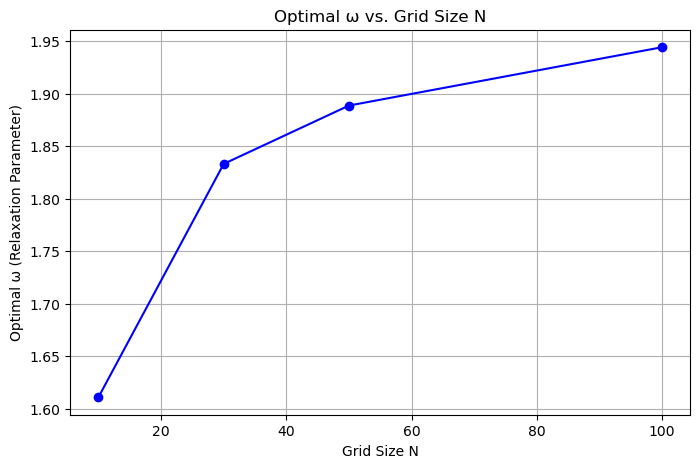

[1.6111111111111112,
 1.8333333333333333,
 1.8888888888888888,
 1.9444444444444444]

In [38]:
def optimal_omega(N_values, D, dt, T, tol=1e-5, omega_list=None):
    if omega_list is None:
        omega_list = np.linspace(1.5, 2.0, 10)  

    optimal_omegas = []  

    plt.figure(figsize=(8, 5))

    for N in N_values:
        iterations = []
        count = 0
        for omega in omega_list:
            iters, _, _ = simulate_diffusion_2d(N, D, 1/N , dt, T, method='SOR', tol=tol, omega=omega)

            if len(iterations) > 1 and iters > 10 * iterations[-1]:
                break
            iterations.append(iters)


        # Find optimal ω for this N
        optimal_idx = np.argmin(iterations)
        optimal_value = omega_list[optimal_idx]
        optimal_omegas.append(optimal_value)


        print(f"For N={N}, Optimal ω: {optimal_value} with {iterations[optimal_idx]} iterations")


    # Plot N vs optimal omega
    plt.figure(figsize=(8, 5))
    plt.plot(N_values, optimal_omegas, marker='o', linestyle='-', color='blue')
    plt.xlabel('Grid Size N')
    plt.ylabel('Optimal ω (Relaxation Parameter)')
    plt.title('Optimal ω vs. Grid Size N')
    plt.grid(True)
    plt.show()

    return optimal_omegas

# Example parameters for running the function
N_values = [10, 30, 50, 100]
D = 1.0     # Diffusion coefficient
dx = 1.0    # Grid spacing
dt = 0.01   # Time step
T = 1.0     # Total simulation time

optimal_omega(N_values, D, dt, T)


In [293]:
import numpy as np

def add_rectangle_sink(grid, x_start, x_end, y_start, y_end):
    """Add a rectangular sink to the grid"""
    grid[x_start:x_end, y_start:y_end] = 0
    return grid

def add_circular_sink(grid, center_x, center_y, radius):
    """Add a circular sink to the grid"""
    N = grid.shape[0]
    for i in range(N):
        for j in range(N):
            if (i - center_x)**2 + (j - center_y)**2 <= radius**2:
                grid[i, j] = 0
    return grid

def get_next_grid(grid, N, dt, D, dx, method, omega, sink_mask=None):
    """Modified get_next_grid to handle sinks"""
    new_grid = grid.copy()
    
    # Create sink mask if not provided
    if sink_mask is None:
        sink_mask = np.zeros_like(grid, dtype=bool)
    
    if method == 'Explicit':
        for i in range(1, N-1):
            for j in range(N):
                if not sink_mask[i,j]:  # Only update non-sink points
                    new_grid[i,j] = grid[i,j] + (dt * D / dx**2) * (
                        grid[i-1, j] + grid[i+1, j] + 
                        grid[i, (j-1) % N] + grid[i, (j+1) % N] - 
                        4 * grid[i,j]
                    )
        return new_grid
        
    elif method == 'SOR':
        max_difference = 0.0
        for i in range(1, N-1):
            for j in range(N):
                if not sink_mask[i,j]:  # Only update non-sink points
                    old_value = grid[i, j]
                    gauss_seidel_value = 0.25 * (
                        new_grid[i-1, j] + grid[i+1, j] + 
                        new_grid[i, (j-1) % N] + grid[i, (j+1) % N]
                    )
                    new_grid[i, j] = (1 - omega) * old_value + omega * gauss_seidel_value
                    max_difference = max(max_difference, abs(new_grid[i, j] - old_value))
        return new_grid, max_difference

def simulate_diffusion_with_sinks(N, D, dx, dt, method="SOR", omega=1.5, tol=1e-6, max_iters=10000):
    """Simulate diffusion with sinks"""
    # Initialize grid
    grid = np.ones((N, N))
    
    # Create sink mask
    sink_mask = np.zeros((N, N), dtype=bool)
    
    # Add some example sinks
    # Rectangle sink
    sink_mask[N//4:N//3, N//4:3*N//4] = True
    grid[sink_mask] = 0
    
    # Store initial state
    c_history = [grid.copy()]
    
    # Iteration loop
    iters = 0
    while True:
        if method == 'Explicit':
            grid = get_next_grid(grid, N, dt, D, dx, method, omega, sink_mask)
        else:
            grid, max_diff = get_next_grid(grid, N, dt, D, dx, method, omega, sink_mask)
            
        if iters % 100 == 0:
            c_history.append(grid.copy())
            
        if method != 'Explicit' and max_diff < tol:
            print(f"Converged after {iters} iterations with max_diff = {max_diff}")
            break
            
        if iters >= max_iters:
            print(f"Failed to converge after {max_iters} iterations")
            break
            
        iters += 1
        
    return c_history, iters

In [294]:
# Test different sink configurations and omega values
def test_sink_configurations():
    N = 100
    D = 1.0
    dx = 1.0
    dt = 0.1
    
    # Test cases
    configs = {
        'no_sinks': lambda g: g,
        'single_rectangle': lambda g: add_rectangle_sink(g, N//4, N//3, N//4, 3*N//4),
        'multiple_rectangles': lambda g: add_rectangle_sink(
            add_rectangle_sink(g, N//4, N//3, N//4, N//2),
            2*N//3, 3*N//4, N//2, 3*N//4
        ),
        'circle': lambda g: add_circular_sink(g, N//2, N//2, N//8)
    }
    
    omega_values = [1.2, 1.5, 1.8]
    
    results = {}
    for config_name, config_func in configs.items():
        results[config_name] = {}
        for omega in omega_values:
            grid = np.ones((N, N))
            grid = config_func(grid)
            _, iters = simulate_diffusion_with_sinks(
                N, D, dx, dt, method='SOR', omega=omega, tol=1e-6
            )
            results[config_name][omega] = iters
            
    return results

# Run tests and analyze results
results = test_sink_configurations()
for config, omega_results in results.items():
    print(f"\nConfiguration: {config}")
    for omega, iters in omega_results.items():
        print(f"  omega = {omega}: {iters} iterations")

Converged after 4849 iterations with max_diff = 9.992582791218396e-07
Converged after 2692 iterations with max_diff = 9.982208473147125e-07
Converged after 1058 iterations with max_diff = 9.936613069028155e-07
Converged after 4849 iterations with max_diff = 9.992582791218396e-07
Converged after 2692 iterations with max_diff = 9.982208473147125e-07
Converged after 1058 iterations with max_diff = 9.936613069028155e-07


KeyboardInterrupt: 

In [2]:
def check_in_mask(x, y, dx, mask_center, mask_dims, mask_type):
    """
    Returns True if (x, y) is inside or on the edge of the mask, False otherwise.
    """
    center_x, center_y = mask_center
    L = mask_dims
    if mask_type == 'Square':
        center_x, center_y = mask_center
        L = mask_dims
        x_min, x_max = center_x - L / 2, center_x + L / 2
        y_min, y_max = center_y - L / 2, center_y + L / 2
        return x_min <= x*dx <= x_max and y_min <= y*dx <= y_max
    elif mask_type == 'Circle':
        R = mask_dims  
        x_real, y_real = x * dx, y * dx  
        distance = np.sqrt((x_real - center_x) ** 2 + (y_real - center_y) ** 2)
        return distance <= R 


In [42]:
def get_next_grid_mask(grid, N, dt, D, dx, method, omega, mask_center, mask_dims, mask_type):
    """
    Performs one iteration of the SOR method to update the grid while respecting the mask.

    Parameters:
    - grid: 2D NumPy array representing the grid
    - N: Grid size (assumes square NxN grid)
    - dt: Time step (not used directly in SOR)
    - D: Diffusion coefficient (not used directly in SOR)
    - dx: Grid spacing
    - method: Numerical method ('SOR' supported)
    - omega: Relaxation parameter for SOR
    - mask_center: Tuple (x_center, y_center) for mask
    - mask_dims: Size of the mask (L for square, R for circle)
    - mask_type: 'Square' or 'Circle'

    Returns:
    - new_grid: Updated grid after one iteration
    - maximum_difference: Maximum change in grid values (for convergence tracking)
    """
    new_grid = np.copy(grid)
    maximum_difference = 0

    if method == 'SOR':
        for i in range(1, N-1):  # Interior points only
            for j in range(N):  # Full range (with periodic BCs in y-direction)
                if not check_in_mask(i, j, dx, mask_center, mask_dims, mask_type):  # Only update if not masked
                    old_value = grid[i, j]
                    gauss_seidel_value = 0.25 * (new_grid[i-1, j] + grid[i+1, j] +  new_grid[i, (j-1) % N] + grid[i, (j+1) % N])
                    new_grid[i, j] = (1 - omega) * old_value + omega * gauss_seidel_value
                    maximum_difference = max(maximum_difference, abs(new_grid[i, j] - old_value))

    return new_grid, maximum_difference

# def get_next_grid_mask(grid, N, dt, D, dx, method, omega, mask_coords, mask_type):
#     new_grid = np.copy(grid)
#     if method == 'SOR':
#         maximum_difference = 0
#         for i in range(1, N-1):
#             for j in range(N):
#                 if (not check_in_mask(i,j,dx, mask_coords, mask_type)):
#                     old_value = grid[i, j]
#                     gauss_seidel_value = 0.25 * (new_grid[i-1, j] + grid[i+1, j] + new_grid[i, (j-1) % N] + grid[i, (j+1) % N])
#                     new_grid[i, j] = (1 - omega) * old_value + omega * (gauss_seidel_value)
#                     maximum_difference = max(maximum_difference, abs(new_grid[i, j] - old_value))
#         return new_grid, maximum_difference

In [40]:
def simulate_diffusion_mask(N, D, dx, dt, T, method, mask_center, mask_dims, mask_type,omega=1.85, tol= 1e-5, save_interval=100):
        c = initialize_grid(N)
        c_history = [c.copy()]
        if method in ['SOR']:
            iters = 0
            max_difference= []
            while True:  
                c, max_diff = get_next_grid_mask(c, N, dt, D, dx, method, omega, mask_center, mask_dims, mask_type)
                
                if iters % save_interval == 0:
                    c_history.append(c.copy())
                    
                if max_diff < tol:
                    print(f"Converged after {iters} iterations")
                    break

                max_difference.append(max_diff)
                iters += 1    
            return iters, c_history, max_difference

Converged after 334 iterations


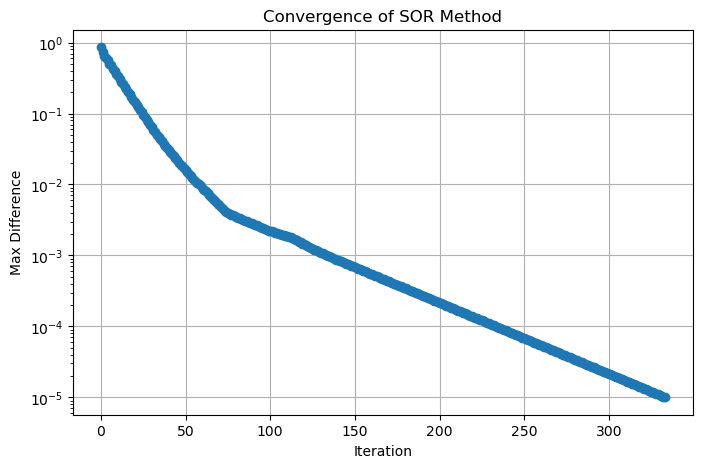

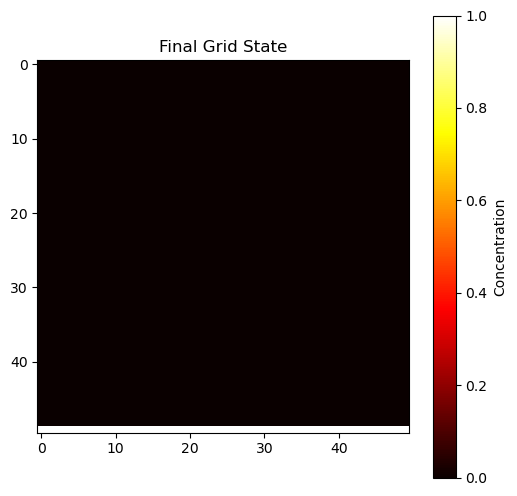

In [10]:
# N = 50      # Number of grid points (must be square grid for provided update function)
# L = 1.0   # Domain size
# dx= L/(N)  # Grid spacing
# D = 1.0              # Diffusion coefficient

# # # Stability-limited time step
# dt = 0.25 * dx**2 / D  
# T = 1.0   
# omega = 1.85  # Relaxation parameter
# tol = 1e-5  # Convergence tolerance
# mask_center = (N//2, N//2)  # Center of mask
# mask_dims = 1 # Size of mask (L for square, R for circle)
# mask_type = 'Square'  # Choose between 'Square' or 'Circle'

# # Run the simulation
# iters, c_history, max_difference = simulate_diffusion_mask(N, D, dx, dt, T, 'SOR', mask_center, mask_dims, mask_type, omega, tol)

# # Plot the convergence behavior
# plt.figure(figsize=(8, 5))
# plt.plot(range(len(max_difference)), max_difference, marker='o', linestyle='-')
# plt.xlabel('Iteration')
# plt.ylabel('Max Difference')
# plt.title('Convergence of SOR Method')
# plt.yscale('log')
# plt.grid(True)
# plt.show()

# # Show the final state of the grid
# plt.figure(figsize=(6, 6))
# plt.imshow(c_history[0], cmap='hot', interpolation='nearest')
# plt.colorbar(label='Concentration')
# plt.title('Final Grid State')
# plt.show()


Running simulation with Mask at (37.5, 25.0), ω=1.5
Converged after 621 iterations


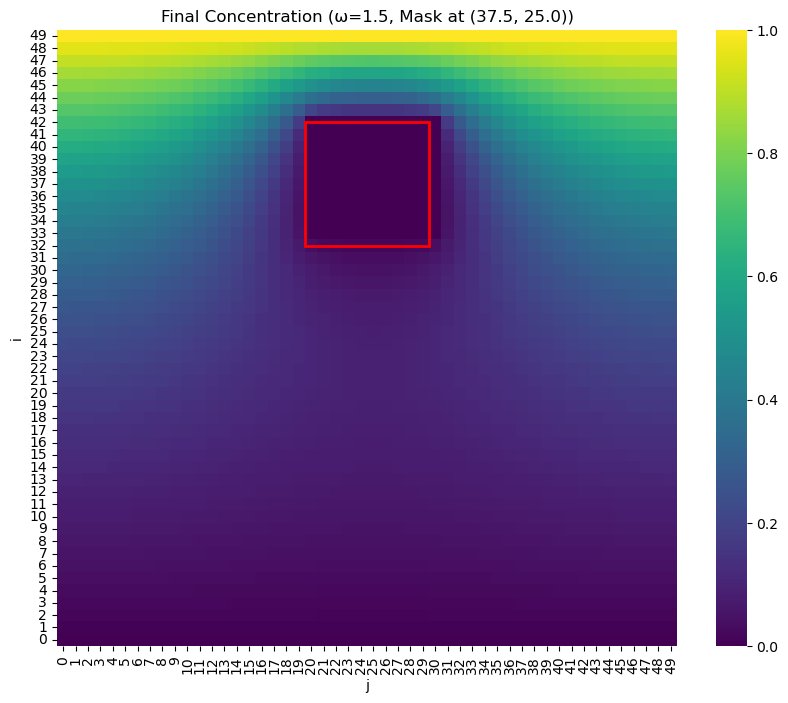

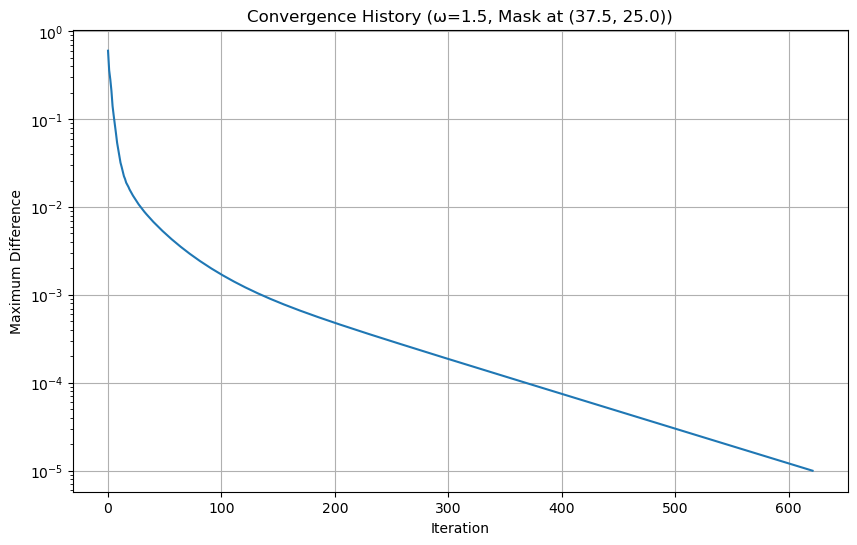

Configuration completed in 621 iterations

Running simulation with Mask at (37.5, 25.0), ω=1.7
Converged after 384 iterations


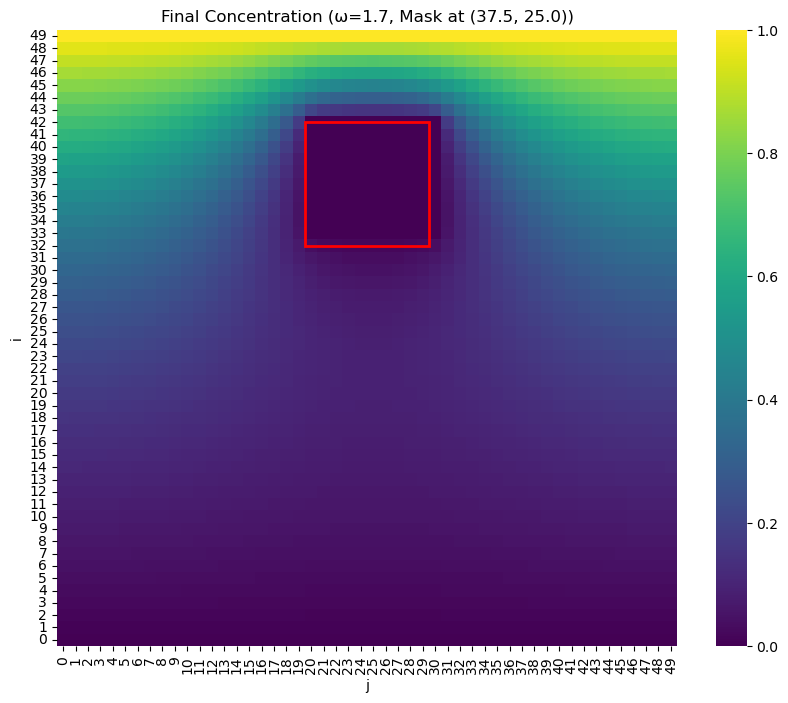

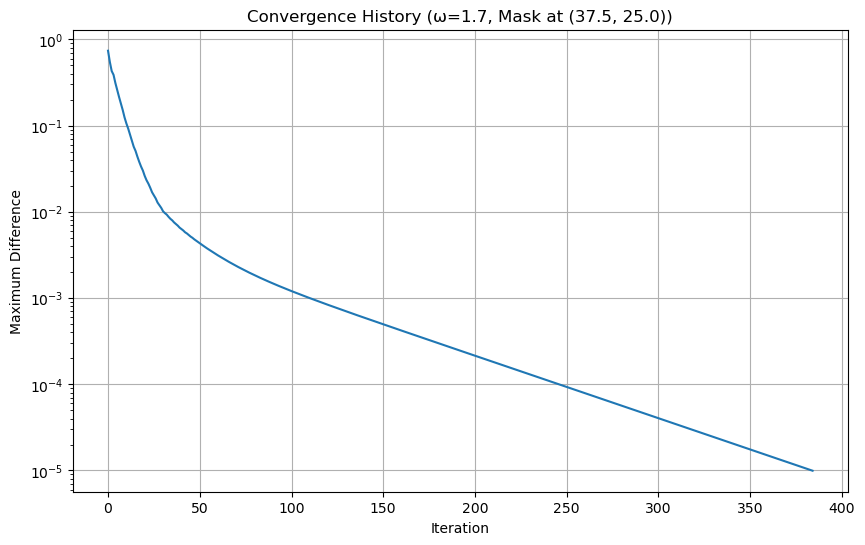

Configuration completed in 384 iterations

Running simulation with Mask at (37.5, 25.0), ω=1.85
Converged after 218 iterations


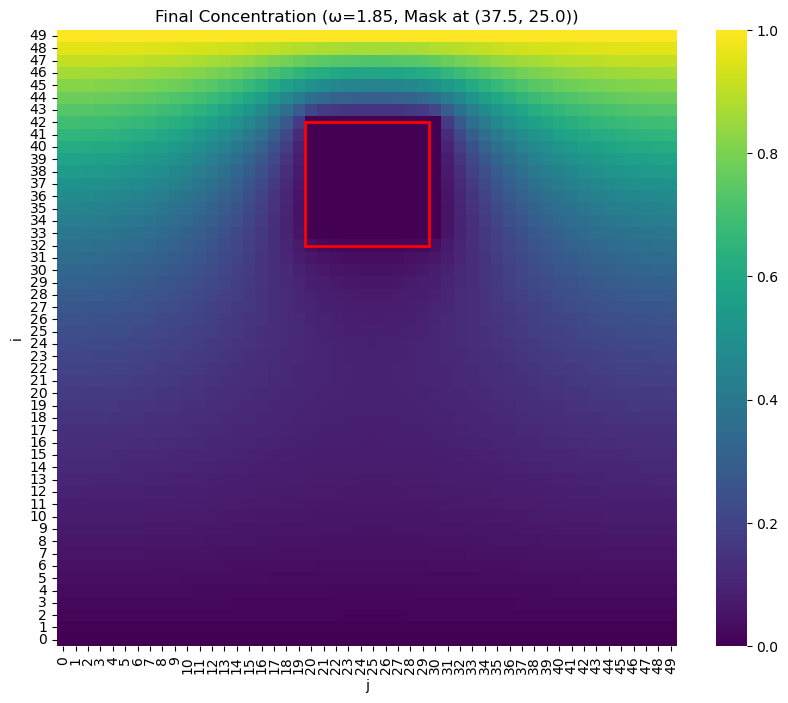

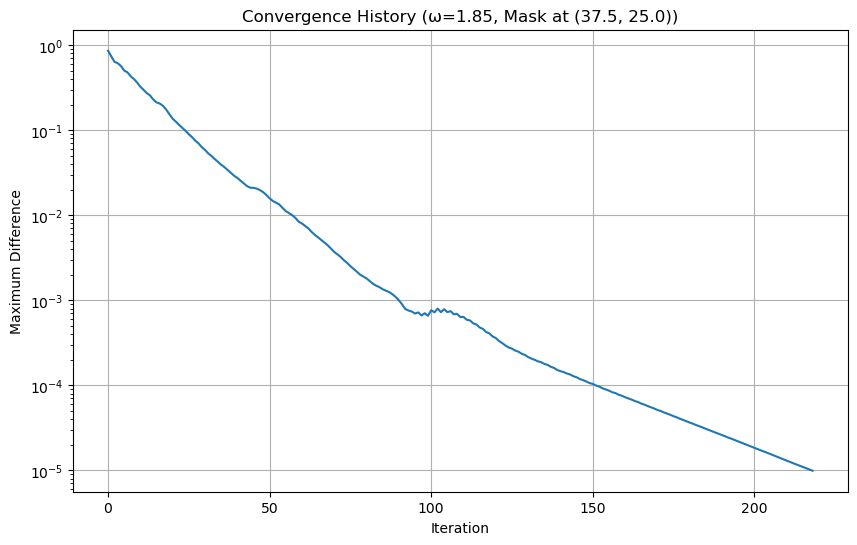

Configuration completed in 218 iterations

Running simulation with Mask at (37.5, 25.0), ω=1.95


KeyboardInterrupt: 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def initialize_grid(N):
    """Initialize the grid with bottom boundary set to 1.0"""
    grid = np.zeros((N, N))
    grid[-1,:] = 1.0  # Set bottom boundary to 1.0
    return grid

def check_in_mask(i, j, dx, mask_center, mask_dims, mask_type):
    """Check if a point is inside the mask"""
    if mask_type == 'rectangle':
        x, y = i * dx, j * dx
        mask_x, mask_y = mask_center
        mask_width, mask_height = mask_dims
        return (abs(x - mask_x) <= mask_width/2 and 
                abs(y - mask_y) <= mask_height/2)
    return False

def plot_concentration(grid, mask_center, mask_dims, dx, title="Concentration Field"):
    """Plot the concentration field with the mask overlay and inverted y-axis"""
    plt.figure(figsize=(10, 8))
    
    # Create heatmap with inverted y-axis
    ax = sns.heatmap(grid, cmap='viridis', vmin=0, vmax=1, 
                     xticklabels=True, yticklabels=True)
    ax.invert_yaxis()  # Invert the y-axis
    
    # Draw rectangle mask
    mask_x, mask_y = mask_center
    mask_width, mask_height = mask_dims
    x = mask_y / dx  # Convert to grid coordinates
    y = mask_x / dx
    width = mask_width / dx
    height = mask_height / dx
    
    rect = plt.Rectangle((x - width/2, y - height/2), width, height,
                        fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)
    
    plt.title(title)
    plt.xlabel('j')
    plt.ylabel('i')
    plt.show()

def run_experiments():
    # Simulation parameters
    N = 50
    D = 1.0
    dx = 1.0
    T = 1.0
    tol = 1e-5
    
    # Test different mask configurations
    mask_configs = [
        # Single rectangle near bottom boundary
        {
            'center': (N*dx*0.75, N*dx/2),  # Placed in lower half
            'dims': (10*dx, 10*dx),
            'type': 'rectangle'
        },
        # Two rectangles at different heights
        {
            'center': (N*dx*0.6, N*dx/3),  # Lower rectangle
            'dims': (8*dx, 8*dx),
            'type': 'rectangle'
        }
    ]
    
    omega_values = [1.5, 1.7, 1.85]
    results = {}
    
    for mask_config in mask_configs:
        mask_name = f"Mask at {mask_config['center']}"
        results[mask_name] = {}
        
        for omega in omega_values:
            print(f"\nRunning simulation with {mask_name}, ω={omega}")
            
            iters, c_history, max_diff = simulate_diffusion_mask(
                N=N, D=D, dx=dx, dt=dt, T=T,
                method='SOR',
                mask_center=mask_config['center'],
                mask_dims=mask_config['dims'],
                mask_type=mask_config['type'],
                omega=omega,
                tol=tol
            )
            
            results[mask_name][omega] = {
                'iterations': iters,
                'final_state': c_history[-1],
                'convergence': max_diff
            }
            
            # Plot final state
            plot_concentration(
                c_history[-1], 
                mask_config['center'], 
                mask_config['dims'], 
                dx,
                f"Final Concentration (ω={omega}, {mask_name})"
            )
            
            # Plot convergence
            plt.figure(figsize=(10, 6))
            plt.semilogy(max_diff)
            plt.title(f"Convergence History (ω={omega}, {mask_name})")
            plt.xlabel("Iteration")
            plt.ylabel("Maximum Difference")
            plt.grid(True)
            plt.show()
            
            # Print iteration count
            print(f"Configuration completed in {iters} iterations")
    
    return results

# Run the experiments
if __name__ == "__main__":
    results = run_experiments()


Running simulation with mask at (37.5, 25.0), ω=1.5
Converged after 621 iterations
(10.0, 10.0)


TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

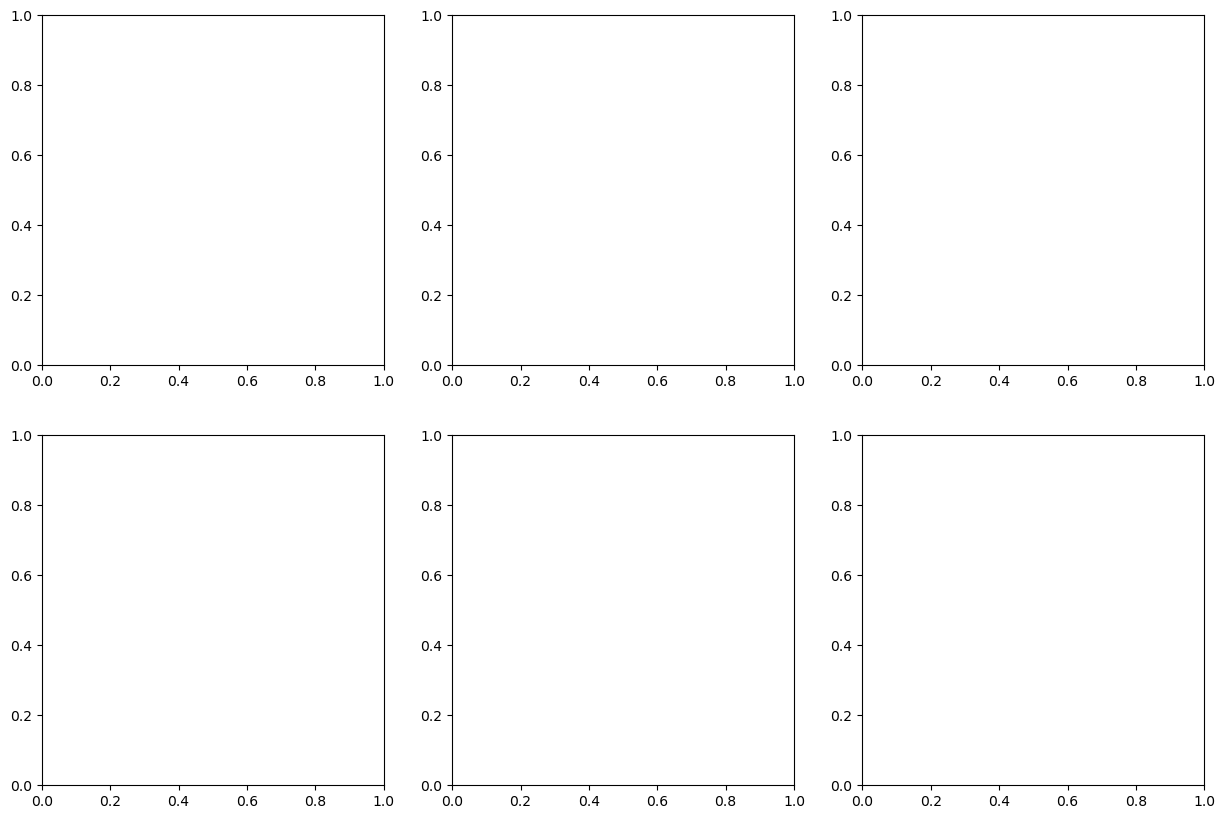

In [44]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# def check_in_mask(i, j, dx, mask_center, mask_dims, mask_type):
#     """Check if a point is inside the mask"""
#     if mask_type == 'rectangle':
#         x, y = i * dx, j * dx
#         mask_x, mask_y = mask_center
#         mask_width, mask_height = mask_dims
#         return (abs(x - mask_x) <= mask_width / 2 and 
#                 abs(y - mask_y) <= mask_height / 2)
#     return False

# # def plot_concentration(grid, mask_center, mask_dims, dx, title="Concentration Field"):
# #     """Plot the concentration field with the mask overlay and inverted y-axis"""
# #     plt.figure(figsize=(10, 8))
    
# #     # Create heatmap with inverted y-axis
# #     ax = sns.heatmap(grid, cmap='viridis', vmin=0, vmax=1, 
# #                      xticklabels=True, yticklabels=True)
# #     ax.invert_yaxis()  # Invert the y-axis
    
# #     # Draw rectangle mask
# #     mask_x, mask_y = mask_center
# #     mask_width, mask_height = mask_dims
# #     x = mask_y / dx  # Convert to grid coordinates
# #     y = mask_x / dx
# #     width = mask_width / dx
# #     height = mask_height / dx
    
# #     rect = plt.Rectangle((x - width / 2, y - height / 2), width, height,
# #                          fill=False, color='red', linewidth=2)
# #     plt.gca().add_patch(rect)
    
# #     plt.title(title)
# #     plt.xlabel('j')
# #     plt.ylabel('i')
# #     plt.show()

# def plot_concentration(times, c_history, N, dx, mask_center=None, mask_dims=None, title="Concentration Field"):
#     """
#     Plot 2D concentration fields for given time steps with an optional mask overlay.

#     Parameters:
#     -----------
#     times : array-like
#         List of time steps at which the concentration fields are evaluated.
#     c_history : list of ndarray
#         List containing the concentration fields at each time step.
#     N : int
#         Size of the grid (number of rows and columns).
#     dx : float
#         Spatial resolution of the grid.
#     mask_center : tuple or None
#         Center coordinates of the mask (i, j). If None, no mask is drawn.
#     mask_dims : tuple or None
#         Dimensions of the mask (width, height). If None, no mask is drawn.
#     title : str
#         Title for the plot.
#     """
    
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#     axes = axes.flatten()
#     N=
#     x = np.linspace(0, (N-1) * dx, N)
#     y = np.linspace(0, (N-1) * dx, N)
#     X, Y = np.meshgrid(x, y)
    
#     for i, (t, c) in enumerate(zip(times, c_history)):
#         if i < len(axes):
#             ax = axes[i]
#             im = ax.pcolormesh(X, Y, c, cmap='viridis', shading='auto')
#             ax.set_title(f't = {t:.3f}')
#             ax.set_xlabel('x')
#             ax.set_ylabel('y')
#             fig.colorbar(im, ax=ax, label='Concentration')

#             # Draw mask if specified
#             if mask_center is not None and mask_dims is not None:
#                 mask_x, mask_y = mask_center
#                 mask_width, mask_height = mask_dims
#                 x_mask = mask_y / dx  # Convert to grid coordinates
#                 y_mask = mask_x / dx
#                 width = mask_width / dx
#                 height = mask_height / dx

#                 rect = plt.Rectangle((x_mask - width / 2, y_mask - height / 2), width, height,
#                                      fill=False, color='red', linewidth=2)
#                 ax.add_patch(rect)
    
#     plt.tight_layout()
#     plt.savefig('concentration_plots.png', dpi=300)
#     plt.show()

# # Example usage
# # times = [0, 0.001, 0.01, 0.1, 1.0]  # Example time steps
# # c_history = [c_field1, c_field2, c_field3, c_field4, c_field5]  # Replace with actual concentration fields
# # plot_concentration(times, c_history, N, dx, mask_center=(mask_i, mask_j), mask_dims=(mask_width, mask_height))

# def run_experiments():
#     # Simulation parameters
#     N = 50
#     D = 1.0
#     dx = 1.0
#     T = 1.0
#     tol = 1e-5
#     dt = 0.01  # Define a time step for the simulation

#     # Mask configuration
#     mask_config = {
#         'center': (N * dx * 0.75, N * dx / 2),  # Placed in lower half
#         'dims': (10 * dx, 10 * dx),
#         'type': 'rectangle'
#     }
    
#     omega_values = [1.5, 1.6, 1.7, 1.8, 1.9]  # List of omega values
#     iterations_list = []  # To store number of iterations for each omega
#     results = {}  # To store results for each omega
    
#     for omega in omega_values:
#         print(f"\nRunning simulation with mask at {mask_config['center']}, ω={omega}")

#         iters, c_history, max_diff = simulate_diffusion_mask(
#             N=N, D=D, dx=dx, dt=dt, T=T,
#             method='SOR',
#             mask_center=mask_config['center'],
#             mask_dims=mask_config['dims'],
#             mask_type=mask_config['type'],
#             omega=omega,
#             tol=tol
#         )
        
#         # Store the number of iterations for the current omega
#         iterations_list.append(iters)
        
#         # Store results for current omega
#         results[omega] = {
#             'iterations': iters,
#             'final_state': c_history[-1],
#             'convergence': max_diff
#         }
        
#         # Plot final state
#         plot_concentration(
#             c_history[-1], 
#             mask_config['center'], 
#             mask_config['dims'], 
#             dx,
#             f"Final Concentration (ω={omega}, Mask at {mask_config['center']})"
#         )
        
#         # Print iteration count
#         print(f"Configuration completed in {iters} iterations")
    
#     # Plot omega vs number of iterations
#     plt.figure(figsize=(10, 6))
#     plt.plot(omega_values, iterations_list, marker='o')
#     plt.title('Omega vs Number of Iterations')
#     plt.xlabel('Omega (ω)')
#     plt.ylabel('Number of Iterations')
#     plt.grid(True)
#     plt.xticks(omega_values)  # Set x-ticks to omega values
#     plt.show()

#     return results

# # Run the experiments
# if __name__ == "__main__":
#     results = run_experiments()



Running simulation with mask at (37.5, 25.0), ω=1.5
Converged after 621 iterations


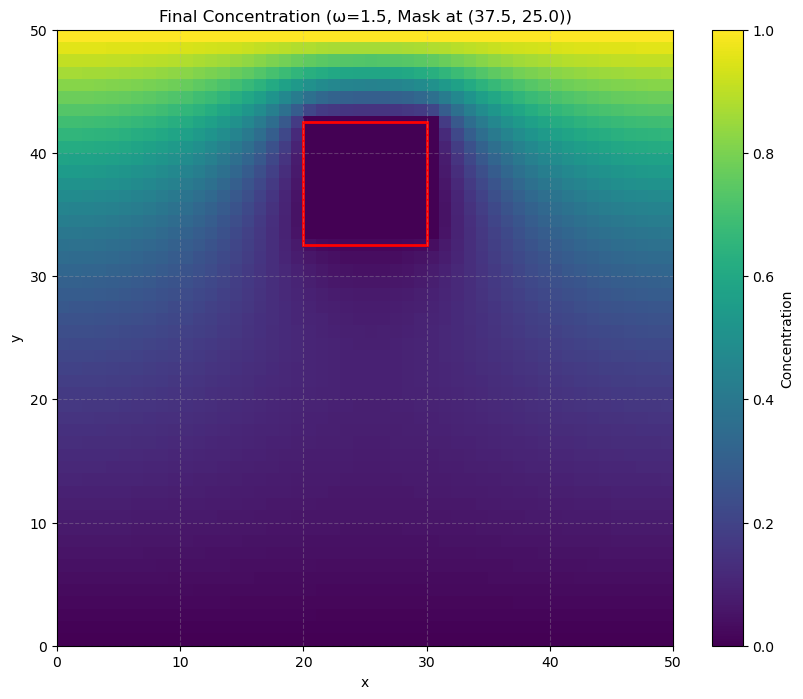

Configuration completed in 621 iterations

Running simulation with mask at (37.5, 25.0), ω=1.5285714285714285
Converged after 586 iterations
Configuration completed in 586 iterations

Running simulation with mask at (37.5, 25.0), ω=1.5571428571428572
Converged after 551 iterations
Configuration completed in 551 iterations

Running simulation with mask at (37.5, 25.0), ω=1.5857142857142856
Converged after 516 iterations
Configuration completed in 516 iterations

Running simulation with mask at (37.5, 25.0), ω=1.6142857142857143
Converged after 482 iterations
Configuration completed in 482 iterations

Running simulation with mask at (37.5, 25.0), ω=1.6428571428571428
Converged after 449 iterations
Configuration completed in 449 iterations

Running simulation with mask at (37.5, 25.0), ω=1.6714285714285713
Converged after 416 iterations
Configuration completed in 416 iterations

Running simulation with mask at (37.5, 25.0), ω=1.7
Converged after 384 iterations
Configuration completed in 3

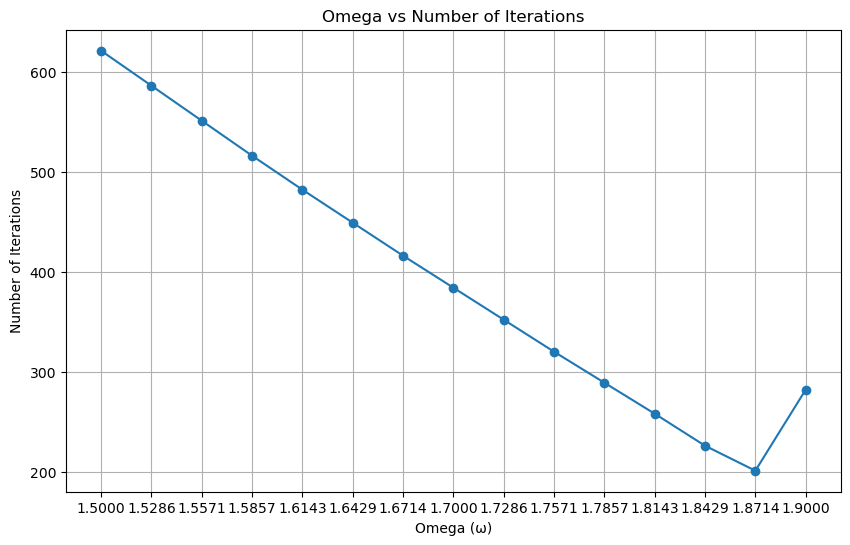

{1.5: {'iterations': 621,
  'final_state': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.00741396, 0.00740816, 0.00738961, ..., 0.00735792, 0.00738914,
          0.00740791],
         [0.01484235, 0.01483064, 0.01479326, ..., 0.01472941, 0.01479232,
          0.01483015],
         ...,
         [0.90884327, 0.90860922, 0.90790039, ..., 0.9066999 , 0.90789881,
          0.90860842],
         [0.95430301, 0.95418477, 0.95382667, ..., 0.95322016, 0.95382588,
          0.95418437],
         [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
          1.        ]]),
  'convergence': [0.6000000000000001,
   0.3600000000000001,
   0.2830957031250001,
   0.21023217773437503,
   0.1409026917480468,
   0.10969343999999939,
   0.08770894850272157,
   0.06892755251467295,
   0.05387613336199701,
   0.04528653473091632,
   0.03861160467575117,
   0.0319400641580013,
   0.028612915498128694,
   0.02525127661728102,
   0.022

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def check_in_mask(i, j, dx, mask_center, mask_dims, mask_type):
    """Check if a point is inside the mask"""
    if mask_type == 'rectangle':
        x, y = i * dx, j * dx
        mask_x, mask_y = mask_center
        mask_width, mask_height = mask_dims
        return (abs(x - mask_x) <= mask_width / 2 and 
                abs(y - mask_y) <= mask_height / 2)
    return False



def plot_concentration(c_grid, mask_center=None, mask_dims=None, dx=1.0, title="Concentration Field"):
    """
    Plot the concentration field with pcolormesh and optional mask overlay.
    
    Parameters:
    -----------
    c_grid : numpy.ndarray
        2D array of concentration values
    mask_center : tuple, optional
        (x, y) coordinates of mask center in physical units
    mask_dims : tuple, optional
        (width, height) of mask in physical units
    dx : float
        Grid spacing
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 8))
    
    # Create mesh grid for pcolormesh
    Ny, Nx = c_grid.shape
    x = np.arange(Nx + 1) * dx
    y = np.arange(Ny + 1) * dx
    X, Y = np.meshgrid(x, y)
    
    # Create pcolormesh plot
    plt.pcolormesh(X, Y, c_grid, 
                  cmap='viridis',
                  vmin=0, 
                  vmax=1,
                  shading='auto')
    
    # Add colorbar
    plt.colorbar(label='Concentration')
    
    # Draw rectangle mask if provided
    if mask_center is not None and mask_dims is not None:
        mask_x, mask_y = mask_center
        mask_width, mask_height = mask_dims
        
        # Create rectangle patch
        rect = plt.Rectangle((mask_y - mask_width/2, mask_x - mask_height/2),
                           mask_width, 
                           mask_height,
                           fill=False,
                           color='red',
                           linewidth=2)
        plt.gca().add_patch(rect)
    
    # Customize plot
    plt.gca().set_aspect('equal')  # Make cells square
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    

    
    # Show grid
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.show()

def run_experiments():
    # Simulation parameters
    N = 50
    D = 1.0
    dx = 1.0
    T = 1.0
    tol = 1e-5
    dt = 0.01  # Define a time step for the simulation

    # Mask configuration
    mask_config = {
        'center': (N * dx * 0.75, N * dx / 2),  # Placed in lower half
        'dims': (10 * dx, 10 * dx),
        'type': 'rectangle'
    }
    
    omega_values = np.linspace(1.5, 1.90, 15)  # List of omega values
    iterations_list = []  # To store number of iterations for each omega
    results = {}  # To store results for each omega
    
    for omega in omega_values:
        print(f"\nRunning simulation with mask at {mask_config['center']}, ω={omega}")

        iters, c_history, max_diff = simulate_diffusion_mask(N=N, D=D, dx=dx, dt=dt, T=T,method='SOR',mask_center=mask_config['center'],mask_dims=mask_config['dims'],mask_type=mask_config['type'],omega=omega,tol=tol)
        
        # Store the number of iterations for the current omega
        iterations_list.append(iters)
        
        # Store results for current omega
        results[omega] = {
            'iterations': iters,
            'final_state': c_history[-1],
            'convergence': max_diff
        }
        
        # Plot final state
        if omega == 1.5:
            plot_concentration(
                c_history[-1],  # Use the final state of the concentration field
                mask_config['center'], 
                mask_config['dims'], 
                dx,
                f"Final Concentration (ω={omega}, Mask at {mask_config['center']})"
            )
            
        # Print iteration count
        print(f"Configuration completed in {iters} iterations")
    
    # Plot omega vs number of iterations
    plt.figure(figsize=(10, 6))
    plt.plot(omega_values, iterations_list, marker='o')
    plt.title('Omega vs Number of Iterations')
    plt.xlabel('Omega (ω)')
    plt.ylabel('Number of Iterations')
    plt.grid(True)
    plt.xticks(omega_values)  # Set x-ticks to omega values
    plt.show()

    return results
run_experiments()

